In [24]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import stormeunice as eun
import sys

sns.set_theme(style="white")
sns.set_style("white")

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

random.seed(10)

In [2]:
def resampleTime(mem_fields, time_ref, resample_freq):

        # get start / end times for properly calculating the maximum fields (taking into account the different preproc times in IFS)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(time_ref.time.values)))
        time_start = time_intersection[0]-pd.Timedelta('{}h 59m'.format(resample_freq-1))
        time_end = time_intersection[-1]

        # get the instantaneous fields + wind speeds
        mem_fields_out = mem_fields.copy()
        
        # get the maximum fields, taking into account the different preproc times
        fg10_field_out = mem_fields.fg10.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq), # resampling freq in hours
                                                                                       label='right',
                                                                                       closed='right',
                                                                                       base=0).max(dim='time')
        mem_fields_out['fg10'] = fg10_field_out

        ws100_field_out = mem_fields.ws100.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq), # resampling freq in hours
                                                                                       label='right',
                                                                                       closed='right',
                                                                                       base=0).mean(dim='time')
        mem_fields_out['ws100'] = ws100_field_out

        return mem_fields_out

# Import data

In [3]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [16]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

In [4]:
# ERA5
era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [5]:
inidate = '2022-02-10'
experiments = ['pi', 'curr', 'incr']
eps = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc


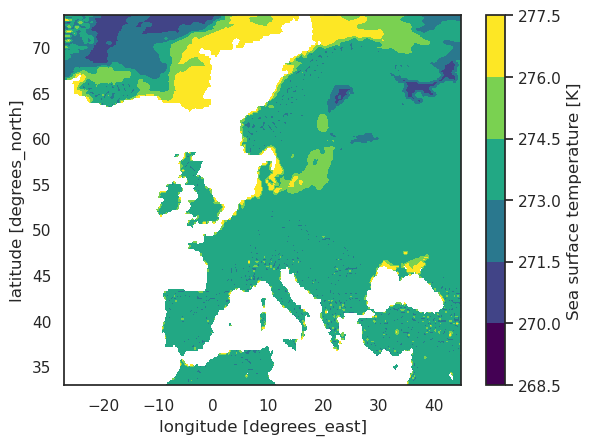

In [6]:
land = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc')
land = land.assign(unknown = land.sst.where(land.sst<277).sel(time = '2022-02-18 12'))
land.unknown.plot.contourf()

In [7]:
eps = {key : eun.data.Data.get_eps_windpseeds(val) for (key,val) in eps.items()}

# Storm severity index (SSI)

Here, we use the definition proposed by Leckebusch et al. 2018 which is dependent on the cube of the wind speeds, the duration and the affected area.
$$ SSI_{T, K} = \sum_t^T \sum_k^K \Big[ \Big( \max{(0, \frac{v_{k,t}}{v_{Perc, k}}-1)}\Big)^3 \times A_k\Big].  $$

For this definition, we first need to calculate the 98th percentile of wind speeds. The threshold for each gridbox is determined on the basis of the 10 preceding years of ERA5, assuming a stationary climate.

# Functions for SSI calculations

In [9]:
def calcArea(lat, lon): 
    degToRad = np.pi / 180
    diffLat, diffLon = -np.diff(lat).mean(), np.diff(lon).mean()
    llat, llon = np.meshgrid(lat,lon)
    llatHalf, llonHalf = (llat+diffLat/2)*degToRad, (llon+diffLon/2)*degToRad
    radius = 6371
    areas = radius**2 * np.diff(llonHalf, axis = 0)[:,:-1] * -((np.cos(llatHalf[:,:-1]) - np.cos(llatHalf[:,1:])))[:-1,:]
    return np.transpose(areas)

In [10]:
def maskOcean(dataset, mask):
    maskedDataset = dataset.where(mask.unknown.notnull, drop = False)
    return(maskedDataset)

In [11]:
def calcSSI(perc98, forecast, type = 'gust', mask = True):

    temp = []
    areas = calcArea(forecast.latitude.values, forecast.longitude.values)

    if mask:
        # land = xr.open_dataset('topo_land.grb')
        land = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc')
        land = land.assign(unknown = land.sst.where(land.sst<277).sel(time = '2022-02-18 12'))

    for time in forecast.time:

        if mask:
            forecastStep = maskOcean(forecast.sel(time = time), land)
        else:
            forecastStep = forecast.sel(time = time)

        if type == 'gust':
            windMax = forecastStep.where((forecastStep.fg10/perc98.fg10-1)**3> 0).fg10.values[1:,1:]
        elif type == 'speed':
            windMax = forecastStep.where((forecastStep.ws100/perc98.ws100-1)**3> 0).fg10.values[1:,1:]
        else:
            raise(ValueError("Type should be one of speed or gust"))
        
        temp.append(np.nansum(np.multiply(windMax, areas)))
        ssi = np.nansum(temp)
    return ssi

# SSI with masked oceans

In [14]:
era5_windspeeds_98perc = eun.data.Data.get_era_98thperc_winds(height = 100)
era5_windgusts_98perc = eun.data.Data.get_era_98thperc_gusts()

In [17]:
resampling_freq = 3 # resampling frequency for wind speeds and gusts in hours
timeref = eps['pi'].sel(number = 1)
ssiGust = {'pi' : [], 'curr' : [], 'incr': []}
ssiSpeed = {'pi' : [], 'curr' : [], 'incr': []}
for experiment in experiments:
    for mem in range(51):
        
        ssiGust[experiment].append(calcSSI(era5_windgusts_98perc.sel(latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])), 
                                           resampleTime(eps[experiment].sel(time = slice('2022-02-16', '2022-02-18'), number = mem, latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])),timeref, resampling_freq), 
                                           mask = True))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pi
curr
incr


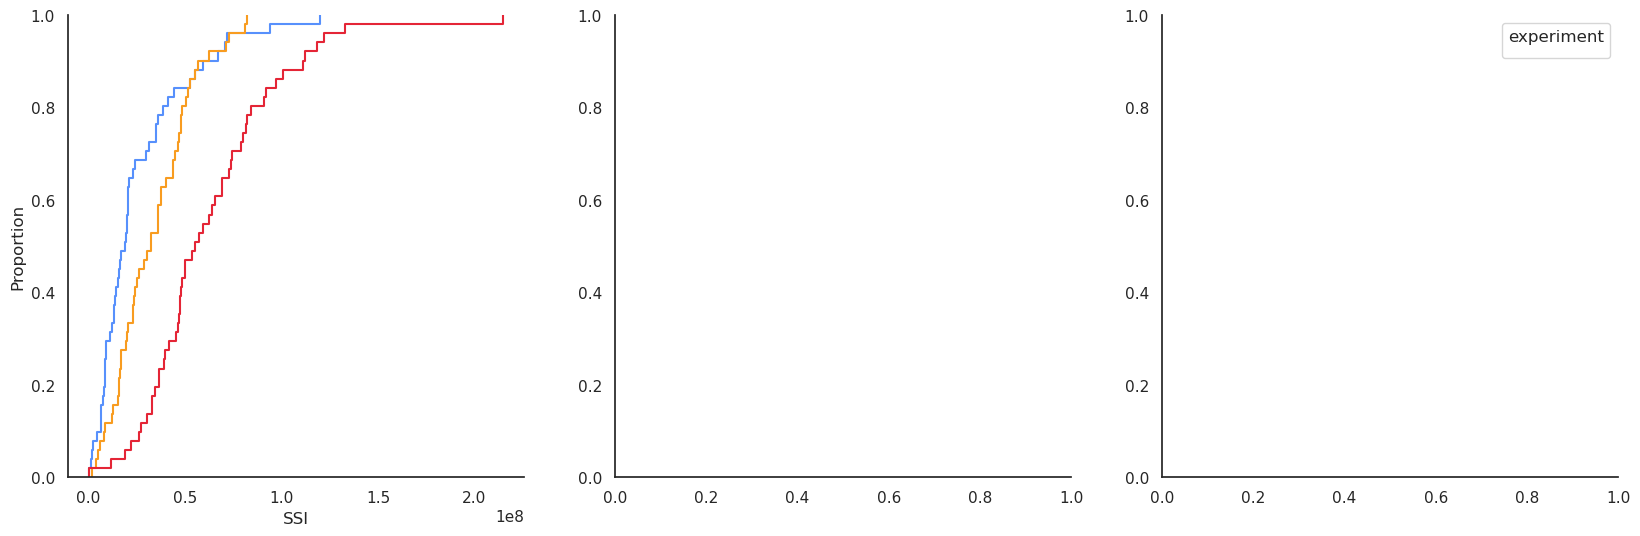

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols =3, figsize = (20,6))

for e, experiment in enumerate(experiments): 
    sns.ecdfplot(ssiGust[experiment], label = experiment, ax = ax1, color = get_palette.Petroff6().to_sn_palette()[e])
    ax1.set_xlabel('SSI')
    

sns.despine()
plt.legend(title = "experiment")

# plt.savefig('figures/PAPER2_SSI_ecdf_inidate_'+inidate+'.png')
# plt.savefig('figures/PAPER2_SSI_ecdf_inidate_'+inidate+'.pdf')
plt.show()